# **0.Import libraries**

In [ ]:
from dataset import load_dataset
# from models.model_2_dropout_imp import ClimatePINN
from train import plot_comparison
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import xarray as xr
from video_gen import load_checkpoint
import json
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
from tqdm.notebook import tqdm as tqdm
%matplotlib inline

# **1.Load data**

In [ ]:
dataset = load_dataset(
    1, 
    train_val_split = None, 
    year0=2000, 
    root_dir="./data/era_5_data",
    normalize=True)

idx = [0,1,2]
inputs, targets = dataset['train'][:]['input'], dataset['train'][:]['target']
geo500 , t850 = inputs[:,0,...], inputs[:,1,...]
t2m, u, v = targets[:,0,...], targets[:,1,...], targets[:,2,...]
inputs = (geo500 , t850)
targets = (t2m, u, v)
lon, lat= dataset['train'][0]['coords'][0], dataset['train'][0]['coords'][1]
dataloader = DataLoader(dataset['train'], batch_size=1, shuffle=False)
batch = next(iter(dataloader))
inputs = batch['input']
targets = batch['target']
masks = batch['masks']
coords = [coord for coord in batch['coords']]

In [ ]:
vars = (geo500 , t850, t2m, u, v)

corr_matrix = np.zeros((5,5))
vars_name = ['input:geo500', 'input:t850', 'target:t2m', 'target:u', 'target:v']
corr_matrix = np.zeros((5, 5, 32, 64))
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=-1, vmax=1)
for x, var_x in tqdm(enumerate(vars)):
    for y, var_y in enumerate(vars):
        corr = pearsonr(var_x, var_y)[0]
        corr_matrix[x,y] = corr

# **2.Correlation**

In [ ]:
# Flatten the arrays
vars = (geo500.flatten(), t850.flatten(), t2m.flatten(), u.flatten(), v.flatten())
vars_name = ['geo500', 't850', 't2m', 'u', 'v']

# Compute the correlation matrix
corr_matrix = np.zeros((5, 5))
for x, var_x in tqdm(enumerate(vars)):
    for y, var_y in enumerate(vars):
        corr = pearsonr(var_x, var_y)[0]
        corr_matrix[x, y] = corr

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the correlation matrix
im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Add color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient')

# Add labels to the matrix
ax.set_xticks(np.arange(len(vars_name)))
ax.set_yticks(np.arange(len(vars_name)))
ax.set_xticklabels(vars_name)
ax.set_yticklabels(vars_name)

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add separators
ax.axvline(x=1.5, color='black', linewidth=2)
ax.axhline(y=1.5, color='black', linewidth=2)

# Annotate the cells with the correlation coefficients
for i in range(len(vars_name)):
    for j in range(len(vars_name)):
        text = ax.text(j, i, f"{corr_matrix[i, j]:.2f}",
                       ha="center", va="center", color="black")

# Add title
plt.title('Correlation Matrix')

# Show plot
plt.show()

# **MSE**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the dataset
dataset = load_dataset(
    10, 
    train_val_split = 0.8,
    root_dir="./data/era_5_data",
    year0=1979,
    normalize=True)

train_dataset, val_dataset = dataset['train'], dataset['val']
test_dataset = load_dataset(
    1,
    train_val_split = None,
    year0=2000,
    root_dir="./data/era_5_data",
    normalize=True)['train']
bs = 16 
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [ ]:
# Create empty lists to collect results
results_data = []

# Define a dictionary of loaders to loop over
loaders = {"train": train_loader, "val": val_loader,"test": test_loader} # 
runs = ['run_1', 'run_3', 'run_4', 'run_8', 'run_9']

for run in tqdm(runs, leave=False, desc="Processing runs"):
    model, epoch, config, device, model_name = load_checkpoint(run, device, checkpoints='./checkpoints', verbose=False)
    
    for ds_name, loader in tqdm(loaders.items(), leave=False, desc=f"Datasets for {model_name}"):
        model.eval()
        mse_loss = 0.0
        phy_loss = 0.0
        count = 0
        
        for batch in tqdm(loader, leave=False, desc=f"Batches in {ds_name}"):
            inp = batch['input'].to(device)
            masks = batch['masks'].to(device)
            coords = [coord.to(device) for coord in batch['coords']]
            target = batch['target'].to(device)
            
            pred = model(inp, masks, coords)
            loss = model.MSE(pred['output'], target)
            mse_loss += loss.item()
            phy_loss += sum(list(pred['physics_loss'].values())).item()
            count += 1
            
            del inp, masks, coords, target, pred, loss
            torch.cuda.empty_cache()
                    
        avg_mse_loss = mse_loss / count if count > 0 else float('nan')
        avg_phy_loss = phy_loss / count if count > 0 else float('nan')
        
        # Append results to list
        results_data.append({
            'model_name': model_name,
            'dataset': ds_name,
            'mse': avg_mse_loss,
            'physics_loss': avg_phy_loss,
            'total_loss': avg_mse_loss + avg_phy_loss
        })
        
    
    del model
    torch.cuda.empty_cache()

# Create DataFrame from collected results after all processing is done
results_df = pd.DataFrame(results_data)

# Save the DataFrame to a CSV file
results_df.to_csv('./outputs/results.csv', index=False)

In [ ]:
results_df = pd.read_csv('./outputs/results.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style 
sns.set_theme(style="whitegrid")

# Option 1: Specify the number of colors needed
palette = sns.color_palette("Set1", n_colors=3)

# Option 2: Or use a specific palette that's commonly used in pairplots
# palette = sns.color_palette("deep")

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x='model_name', y='mse', hue='dataset', data=results_df, ax=ax[0], palette=palette)
ax[0].set_title("MSE Loss")
ax[0].set_ylabel("Loss")
ax[0].set_yscale("log")

sns.barplot(x='model_name', y='physics_loss', hue='dataset', data=results_df, ax=ax[1], palette=palette)
ax[1].set_title("Physics Loss")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")

sns.barplot(x='model_name', y='total_loss', hue='dataset', data=results_df, ax=ax[2], palette=palette)
ax[2].set_title("Total Loss")
ax[2].set_ylabel("Loss")
ax[2].set_yscale("log")

plt.tight_layout()
plt.savefig('./outputs/barplot.png')
plt.show()

In [ ]:
# Assuming results_df already exists with columns 'model_name', 'dataset', 'mse', 'physics_loss', 'total_loss'
import numpy as np
import pandas as pd

# Replace underscores in model names for LaTeX display
results_df['model_display'] = results_df['model_name'].apply(lambda x: x.replace('_', r'\_'))

# Find the best (minimum) values for each metric in each dataset
best_values = {}
for dataset in ['train', 'val', 'test']:
    dataset_df = results_df[results_df['dataset'] == dataset]
    for metric in ['mse', 'physics_loss', 'total_loss']:
        best_values[(dataset, metric)] = dataset_df[metric].min()

# Format values with scientific notation where appropriate
def format_value(value, is_best=False):
    if np.isnan(value):
        return "N/A"
    # Use scientific notation for very small values
    elif abs(value) < 0.001 or abs(value) >= 10000:
        formatted = f"{value:.2e}"
    else:
        formatted = f"{value:.4f}"
    
    # Add bold formatting for best values
    if is_best:
        return f"\\textbf{{{formatted}}}"
    return formatted

# Get unique model names (preserving order)
unique_models = results_df[results_df['dataset'] == 'train']['model_name'].tolist()
model_displays = results_df[results_df['dataset'] == 'train']['model_display'].tolist()

# Create a reorganized table by metric type
latex_table = r"""\begin{table}[htbp]
\centering
\caption{Comparison of models across different metrics and datasets. Best values in each category are highlighted in bold.}
\label{tab:results}
\begin{tabular}{lcccc}
\toprule
& \multicolumn{4}{c}{MSE} \\
\cmidrule(lr){2-5}
Model & Train & Val & Test & Average \\
\midrule
"""

# MSE section
for i, model_name in enumerate(unique_models):
    model_display = model_displays[i]
    
    mse_train = results_df[(results_df['model_name'] == model_name) & (results_df['dataset'] == 'train')]['mse'].values[0]
    mse_val = results_df[(results_df['model_name'] == model_name) & (results_df['dataset'] == 'val')]['mse'].values[0]
    mse_test = results_df[(results_df['model_name'] == model_name) & (results_df['dataset'] == 'test')]['mse'].values[0]
    mse_avg = (mse_train + mse_val + mse_test) / 3
    
    is_best_mse_train = abs(mse_train - best_values[('train', 'mse')]) < 1e-10
    is_best_mse_val = abs(mse_val - best_values[('val', 'mse')]) < 1e-10
    is_best_mse_test = abs(mse_test - best_values[('test', 'mse')]) < 1e-10
    
    latex_table += f"{model_display} & {format_value(mse_train, is_best_mse_train)} & {format_value(mse_val, is_best_mse_val)} & {format_value(mse_test, is_best_mse_test)} & {format_value(mse_avg)} \\\\\n"

# Physics loss section
latex_table += r"""\midrule
& \multicolumn{4}{c}{Physics Loss} \\
\cmidrule(lr){2-5}
Model & Train & Val & Test & Average \\
\midrule
"""

for i, model_name in enumerate(unique_models):
    model_display = model_displays[i]
    
    phy_train = results_df[(results_df['model_name'] == model_name) & (results_df['dataset'] == 'train')]['physics_loss'].values[0]
    phy_val = results_df[(results_df['model_name'] == model_name) & (results_df['dataset'] == 'val')]['physics_loss'].values[0]
    phy_test = results_df[(results_df['model_name'] == model_name) & (results_df['dataset'] == 'test')]['physics_loss'].values[0]
    phy_avg = (phy_train + phy_val + phy_test) / 3
    
    is_best_phy_train = abs(phy_train - best_values[('train', 'physics_loss')]) < 1e-10
    is_best_phy_val = abs(phy_val - best_values[('val', 'physics_loss')]) < 1e-10
    is_best_phy_test = abs(phy_test - best_values[('test', 'physics_loss')]) < 1e-10
    
    latex_table += f"{model_display} & {format_value(phy_train, is_best_phy_train)} & {format_value(phy_val, is_best_phy_val)} & {format_value(phy_test, is_best_phy_test)} & {format_value(phy_avg)} \\\\\n"

# Total loss section
latex_table += r"""\midrule
& \multicolumn{4}{c}{Total Loss} \\
\cmidrule(lr){2-5}
Model & Train & Val & Test & Average \\
\midrule
"""

for i, model_name in enumerate(unique_models):
    model_display = model_displays[i]
    
    total_train = results_df[(results_df['model_name'] == model_name) & (results_df['dataset'] == 'train')]['total_loss'].values[0]
    total_val = results_df[(results_df['model_name'] == model_name) & (results_df['dataset'] == 'val')]['total_loss'].values[0]
    total_test = results_df[(results_df['model_name'] == model_name) & (results_df['dataset'] == 'test')]['total_loss'].values[0]
    total_avg = (total_train + total_val + total_test) / 3
    
    is_best_total_train = abs(total_train - best_values[('train', 'total_loss')]) < 1e-10
    is_best_total_val = abs(total_val - best_values[('val', 'total_loss')]) < 1e-10
    is_best_total_test = abs(total_test - best_values[('test', 'total_loss')]) < 1e-10
    
    latex_table += f"{model_display} & {format_value(total_train, is_best_total_train)} & {format_value(total_val, is_best_total_val)} & {format_value(total_test, is_best_total_test)} & {format_value(total_avg)} \\\\\n"

# Close the table
latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

# Save the LaTeX table to a file
with open("./outputs/results_article_table.txt", "w") as f:
    f.write(latex_table)
print("LaTeX table has been exported to 'results_article_table.txt'")

In [16]:
import wandb
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
# Set your wandb API key
# os.environ["WANDB_API_KEY"] = "YOUR_API_KEY_HERE"

# Initialize wandb and connect to your project
api = wandb.Api()
entity = "enzo-louvard-ensta-paris"  # Your wandb username or organization
project = "climate_pinn"             # Your project name

# Get runs data
runs = api.runs(f"{entity}/{project}")

# Maximum number of steps to include (adjust as needed)
MAX_STEPS = 25000
# Sampling rate (to reduce data points and keep chart performant)
SAMPLING_RATE = 1  # Get every Nth step

# Extract the metrics you need for visualization
data = []
model_run = {"run_1": "model_0",
             "run_3": "model_1",
             "run_4": "model_0_Re",
             "run_8": "model_2",
             "run_9": "model_3"}
model_data = {}

for run in runs:
    run_name = run.name
    if run_name in ["run_1", "run_3", "run_4", "run_8", "run_9"]:
        print(f"Fetching history for {run_name}...")
        
        # Get the history metrics for data loss
        try:
            history = run.history(samples=MAX_STEPS//SAMPLING_RATE, keys=["batch/data_loss", "_step"])
            
            # Convert to list of [step, value] pairs and sample every Nth point
            steps = history["_step"].tolist()
            data_loss = history["batch/data_loss"].tolist()
            
            # Create pairs of [step, value]
            step_loss_pairs = [[steps[i], data_loss[i]] for i in range(len(steps)) if i % SAMPLING_RATE == 0]
            
            # Store in model_data dictionary
            model_data[model_run[run_name]] = {
                "data_loss": step_loss_pairs
            }
            
            print(f"  Got {len(step_loss_pairs)} data points for {run_name}")
        except Exception as e:
            print(f"Error fetching history for {run_name}: {e}")

Fetching history for run_1...
  Got 10000 data points for run_1
Fetching history for run_3...
  Got 10000 data points for run_3
Fetching history for run_4...
  Got 10000 data points for run_4
Fetching history for run_8...
  Got 10000 data points for run_8
Fetching history for run_9...
  Got 10000 data points for run_9


In [10]:
import numpy as np
import matplotlib.pyplot as plt

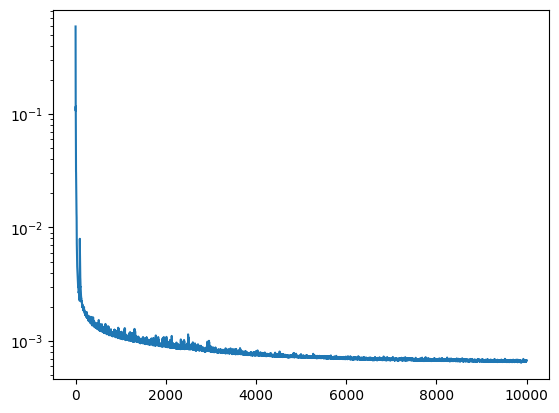

In [17]:
plt.semilogy(np.array(model_data['model_2']['data_loss'])[:,1])